In [30]:
# 加载所需的库和数据
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

def load_data(file_name):
    df = pd.read_csv("D:/Innovation/DataSet/" + file_name ,encoding='gbk')
    columns = df.columns
    df.fillna(df.mean(numeric_only=True) ,inplace=True)
    return df

In [2]:
test = load_data('test.csv')
amount = load_data('amount.csv')
address = load_data('address.csv')

In [3]:
label = pd.concat([amount, address], axis=1)
label

,0,商户名称_B02公寓浴池,商户名称_B07公寓浴池,商户名称_一区饺子园主食一组,商户名称_一区饺子园凉菜组,商户名称_中央红小月亮B02,商户名称_中央红小月亮门店5,商户名称_南苑特色铁板烧,商户名称_友来副食一组,商户名称_友来小猪憨尼麻辣烫,...,商户名称_锦绣食堂水吧,商户名称_锦绣食堂湘汁拌饭,商户名称_锦绣食堂王记手工土豆粉,商户名称_锦绣食堂这家有面,商户名称_阳光副食二组,商户名称_阳光小是小简餐,商户名称_阳光川蜀源烤鱼,商户名称_阳光广式猪脚饭,商户名称_骄子园主食一组,商户名称_骄子园主食二组
0,0.286867,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.381736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.419167,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.085189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.593417,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0.451436,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1392,0.005808,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1393,0.005163,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1394,0.002581,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
label.iloc[0, :]

0                 0.286867
商户名称_B02公寓浴池      0.000000
商户名称_B07公寓浴池      0.000000
商户名称_一区饺子园主食一组    0.000000
商户名称_一区饺子园凉菜组     0.000000
                    ...   
商户名称_阳光小是小简餐      0.000000
商户名称_阳光川蜀源烤鱼      0.000000
商户名称_阳光广式猪脚饭      0.000000
商户名称_骄子园主食一组      0.000000
商户名称_骄子园主食二组      0.000000
Name: 0, Length: 83, dtype: float64

In [5]:
'''
dataset 代表特征数据
start_index 代表从数据的第几个索引值开始取
history_size 滑动窗口大小
end_index 代表数据取到哪个索引就结束
target_size 代表预测未来某一时间点还是时间段的气温。例如target_size=0代表用前20个特征预测第21个的气温
step 代表在滑动窗口中每隔多少步取一组特征
point_time 布尔类型，用来表示预测未来某一时间点的气温，还是时间段的气温
true 原始气温数据的所有标签值
'''
 
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值
    
    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]
    
    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size
        
    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):
        
        # 滑窗中的值不全部取出来用，每隔60min取一次
        index = range(i-history_size, i, step)  # 第一次相当于range(0, start_index, 6)
        
        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true.iloc[i+target_size, :])
        
        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i+target_size, :])
    
    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)

In [6]:
train_size = int(len(test) * 0.6)
val_size = int(len(test) * 0.8)

In [7]:
#划分数据集
history_size = 20
target_size =  0  # 预测未来下一个时间点
step = 1  # 步长为1取所有的行
 
# 构造训练集
x_train, y_train = TimeSeries(dataset=test, start_index=0, history_size=history_size, end_index=train_size,
                              step=step, target_size=target_size, point_time=True, true=label)
 
# 构造验证集
x_val, y_val = TimeSeries(dataset=test, start_index=train_size, history_size=history_size, end_index=val_size,
                          step=step, target_size=target_size, point_time=True, true=label)
 
# 构造测试集
x_test, y_test =  TimeSeries(dataset=test, start_index=val_size, history_size=history_size, end_index=len(test),
                              step=step, target_size=target_size, point_time=True, true=label)
 
# 查看数据集信息
print('x_train_shape:', x_train.shape) 
print('y_train_shape:', y_train.shape)

x_train_shape: (817, 20, 22)
y_train_shape: (817, 83)


In [8]:
y_train[:,0]

array([7.22491126e-01, 4.19167473e-01, 1.12616973e-01, 3.12681510e-01,
       3.22362052e-01, 6.57954179e-01, 1.64246531e-01, 3.86899000e-01,
       5.29202969e-02, 2.90093579e-01, 4.19167473e-01, 5.35333979e-01,
       5.29202969e-02, 3.86899000e-01, 3.03000968e-01, 5.99870926e-01,
       9.48693127e-02, 3.28815747e-01, 3.22362052e-01, 1.61019684e-01,
       3.28815747e-01, 6.42142627e-02, 2.57825105e-01, 5.61148758e-01,
       4.00129074e-02, 2.19102936e-01, 4.70797031e-01, 3.54630526e-01,
       1.64246531e-01, 6.57954179e-01, 2.96547273e-01, 1.15843821e-01,
       5.61148758e-01, 4.19167473e-01, 5.87286221e-02, 3.22362052e-01,
       2.57825105e-01, 3.86899000e-01, 1.12616973e-01, 3.69151339e-01,
       1.12616973e-01, 3.86899000e-01, 5.80509842e-01, 9.64827364e-02,
       2.35237173e-01, 3.22362052e-01, 4.51435947e-01, 5.29202969e-02,
       1.93288157e-01, 4.42723459e-01, 3.54630526e-01, 1.69086802e-01,
       2.90416263e-03, 1.86834463e-01, 4.19167473e-01, 3.22362052e-01,
      

In [15]:
(y_train[:,1:]).astype(np.int64)
y_train[:,1:].dtype

dtype('float64')

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
amount_train = y_train[:,0]
amount_train

array([7.22491126e-01, 4.19167473e-01, 1.12616973e-01, 3.12681510e-01,
       3.22362052e-01, 6.57954179e-01, 1.64246531e-01, 3.86899000e-01,
       5.29202969e-02, 2.90093579e-01, 4.19167473e-01, 5.35333979e-01,
       5.29202969e-02, 3.86899000e-01, 3.03000968e-01, 5.99870926e-01,
       9.48693127e-02, 3.28815747e-01, 3.22362052e-01, 1.61019684e-01,
       3.28815747e-01, 6.42142627e-02, 2.57825105e-01, 5.61148758e-01,
       4.00129074e-02, 2.19102936e-01, 4.70797031e-01, 3.54630526e-01,
       1.64246531e-01, 6.57954179e-01, 2.96547273e-01, 1.15843821e-01,
       5.61148758e-01, 4.19167473e-01, 5.87286221e-02, 3.22362052e-01,
       2.57825105e-01, 3.86899000e-01, 1.12616973e-01, 3.69151339e-01,
       1.12616973e-01, 3.86899000e-01, 5.80509842e-01, 9.64827364e-02,
       2.35237173e-01, 3.22362052e-01, 4.51435947e-01, 5.29202969e-02,
       1.93288157e-01, 4.42723459e-01, 3.54630526e-01, 1.69086802e-01,
       2.90416263e-03, 1.86834463e-01, 4.19167473e-01, 3.22362052e-01,
      

In [20]:
place_train = y_train[:,1:]
place_train = place_train.astype(np.int64)

In [22]:
amount_val = y_val[:,0]
place_val = y_val[:, 1:].astype(np.int64)

amount_test = y_test[:,0]
place_test =  y_test[:, 1:].astype(np.int64)

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, (amount_train, place_train)))  # 训练集
train_ds = train_ds.batch(128).shuffle(10000)  # 随机打乱、每个step处理128组数据
 
val_ds = tf.data.Dataset.from_tensor_slices((x_val, (amount_val, place_val)))  # 验证集
val_ds = val_ds.batch(128)  
 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, (amount_test, place_test)))  # 测试集
test_ds = test_ds.batch(128)  
 
# 查看数据集信息
sample = next(iter(train_ds))  # 取出一个batch的数据
print('x_train.shape:', sample[0].shape)  # [128, 720, 10]

x_train.shape: (128, 20, 22)


In [25]:
sample[1]

(<tf.Tensor: shape=(128,), dtype=float64, numpy=
 array([0.72249113, 0.41916747, 0.11261697, 0.31268151, 0.32236205,
        0.65795418, 0.16424653, 0.386899  , 0.0529203 , 0.29009358,
        0.41916747, 0.53533398, 0.0529203 , 0.386899  , 0.30300097,
        0.59987093, 0.09486931, 0.32881575, 0.32236205, 0.16101968,
        0.32881575, 0.06421426, 0.2578251 , 0.56114876, 0.04001291,
        0.21910294, 0.47079703, 0.35463053, 0.16424653, 0.65795418,
        0.29654727, 0.11584382, 0.56114876, 0.41916747, 0.05872862,
        0.32236205, 0.2578251 , 0.386899  , 0.11261697, 0.36915134,
        0.11261697, 0.386899  , 0.58050984, 0.09648274, 0.23523717,
        0.32236205, 0.45143595, 0.0529203 , 0.19328816, 0.44272346,
        0.35463053, 0.1690868 , 0.00290416, 0.18683446, 0.41916747,
        0.32236205, 0.386899  , 0.11584382, 0.39335269, 0.11261697,
        0.19328816, 0.386899  , 0.35463053, 0.11261697, 0.2578251 ,
        0.386899  , 0.16101968, 0.19328816, 0.43788319, 0.74185221,

In [28]:
sample[1][1].shape[1]

82

In [32]:
from tensorflow.keras.models import Model

In [69]:
# 定义模型输入
inputs_shape = sample[0].shape[1:]  # 不需要写batch的维度大小
num_place = sample[1][1].shape[1]
inputs = keras.Input(shape=inputs_shape)  # 输入层
 

# LSTM层
x = LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# 地点输出层
place_out = Dense(num_place, activation='softmax', name='place_out')(x)

# 金额输出层
amount_out = Dense(1, activation='relu', name='amount_out')(x)

# 定义模型输出
outputs = ([amount_out, place_out])

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(optimizer = keras.optimizers.Adam(0.01),
              loss={'place_out': 'categorical_crossentropy', 'amount_out': 'mean_squared_error'},
              metrics={'place_out': 'accuracy', 'amount_out': 'mae'})

In [70]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 20, 22)]     0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 20, 128)      77312       input_17[0][0]                   
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 20, 64)       49408       lstm_24[0][0]                    
__________________________________________________________________________________________________
lstm_26 (LSTM)                  (None, 32)           12416       lstm_25[0][0]                    
___________________________________________________________________________________________

In [71]:
epochs = 250  # 网络迭代次数
 
# 网络训练
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
 
# 测试集评价
model.evaluate(test_ds)  # loss: 0.1212

Epoch 1/250
7/7 [==============================] - 4s 162ms/step - loss: 6.2486 - amount_out_loss: 0.0929 - place_out_loss: 4.2654 - amount_out_mae: 0.2542 - place_out_accuracy: 0.0490 - val_loss: 5.5107 - val_amount_out_loss: 0.0680 - val_place_out_loss: 4.5233 - val_amount_out_mae: 0.2302 - val_place_out_accuracy: 0.0000e+00
Epoch 2/250
7/7 [==============================] - 0s 63ms/step - loss: 4.5031 - amount_out_loss: 0.0786 - place_out_loss: 3.7028 - amount_out_mae: 0.2262 - place_out_accuracy: 0.1297 - val_loss: 3.5427 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9355 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 3/250
7/7 [==============================] - 0s 60ms/step - loss: 4.1504 - amount_out_loss: 0.0779 - place_out_loss: 3.5447 - amount_out_mae: 0.2271 - place_out_accuracy: 0.0379 - val_loss: 3.4481 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9518 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 4/250
7/7 [======

7/7 [==============================] - 1s 108ms/step - loss: 3.7368 - amount_out_loss: 0.0903 - place_out_loss: 3.3252 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.2968 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9451 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 27/250
7/7 [==============================] - 1s 105ms/step - loss: 3.7348 - amount_out_loss: 0.0903 - place_out_loss: 3.3376 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.4011 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0627 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 28/250
7/7 [==============================] - 1s 106ms/step - loss: 3.7410 - amount_out_loss: 0.0903 - place_out_loss: 3.3572 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.2118 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.8853 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 29/250
7/7 [=================

7/7 [==============================] - 1s 103ms/step - loss: 3.6040 - amount_out_loss: 0.0903 - place_out_loss: 3.3361 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0110 - val_loss: 3.2309 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0158 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 52/250
7/7 [==============================] - 1s 112ms/step - loss: 3.6046 - amount_out_loss: 0.0903 - place_out_loss: 3.3402 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1410 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9292 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 53/250
7/7 [==============================] - 1s 109ms/step - loss: 3.6187 - amount_out_loss: 0.0903 - place_out_loss: 3.3570 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0024 - val_loss: 3.4203 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.2111 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.0000e+00
Epoch 54/250
7/7 [=============

7/7 [==============================] - 1s 105ms/step - loss: 3.5470 - amount_out_loss: 0.0903 - place_out_loss: 3.3283 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0857 - val_loss: 3.1512 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9840 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 77/250
7/7 [==============================] - 1s 105ms/step - loss: 3.5481 - amount_out_loss: 0.0903 - place_out_loss: 3.3304 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0110 - val_loss: 3.2746 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.1084 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.0000e+00
Epoch 78/250
7/7 [==============================] - 1s 111ms/step - loss: 3.5329 - amount_out_loss: 0.0903 - place_out_loss: 3.3164 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1053 - val_loss: 3.2186 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0538 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 79/250
7/7 [=============

7/7 [==============================] - 1s 106ms/step - loss: 3.5375 - amount_out_loss: 0.0903 - place_out_loss: 3.3454 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.2313 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0907 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 102/250
7/7 [==============================] - 1s 105ms/step - loss: 3.5079 - amount_out_loss: 0.0903 - place_out_loss: 3.3168 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0490 - val_loss: 3.1685 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0288 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 103/250
7/7 [==============================] - 1s 105ms/step - loss: 3.5044 - amount_out_loss: 0.0903 - place_out_loss: 3.3142 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1951 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0564 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 104/250
7/7 [==============

7/7 [==============================] - 1s 103ms/step - loss: 3.4831 - amount_out_loss: 0.0903 - place_out_loss: 3.3097 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1114 - val_loss: 3.2411 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.1191 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 127/250
7/7 [==============================] - 1s 103ms/step - loss: 3.4968 - amount_out_loss: 0.0903 - place_out_loss: 3.3243 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1254 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0043 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 128/250
7/7 [==============================] - 1s 107ms/step - loss: 3.4950 - amount_out_loss: 0.0903 - place_out_loss: 3.3233 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1368 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0166 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 129/250
7/7 [==============

7/7 [==============================] - 1s 104ms/step - loss: 3.4852 - amount_out_loss: 0.0903 - place_out_loss: 3.3261 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1280 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0202 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 152/250
7/7 [==============================] - 1s 111ms/step - loss: 3.4854 - amount_out_loss: 0.0903 - place_out_loss: 3.3268 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.0860 - val_amount_out_loss: 0.0394 - val_place_out_loss: 2.9786 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 153/250
7/7 [==============================] - 1s 103ms/step - loss: 3.4784 - amount_out_loss: 0.0903 - place_out_loss: 3.3200 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1592 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0518 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 154/250
7/7 [==============

7/7 [==============================] - 1s 111ms/step - loss: 3.4677 - amount_out_loss: 0.0903 - place_out_loss: 3.3163 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1024 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0021 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 177/250
7/7 [==============================] - 1s 102ms/step - loss: 3.4647 - amount_out_loss: 0.0903 - place_out_loss: 3.3135 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1339 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0338 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 178/250
7/7 [==============================] - 1s 102ms/step - loss: 3.4613 - amount_out_loss: 0.0903 - place_out_loss: 3.3104 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1700 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0703 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 179/250
7/7 [==============

7/7 [==============================] - 1s 102ms/step - loss: 3.4573 - amount_out_loss: 0.0903 - place_out_loss: 3.3095 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1544 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0577 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 202/250
7/7 [==============================] - 1s 101ms/step - loss: 3.4609 - amount_out_loss: 0.0903 - place_out_loss: 3.3133 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1977 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.1013 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 203/250
7/7 [==============================] - 1s 102ms/step - loss: 3.4590 - amount_out_loss: 0.0903 - place_out_loss: 3.3119 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1794 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0835 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 204/250
7/7 [==============

7/7 [==============================] - 1s 102ms/step - loss: 3.4590 - amount_out_loss: 0.0903 - place_out_loss: 3.3136 - amount_out_mae: 0.2493 - place_out_accuracy: 0.0245 - val_loss: 3.1552 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0610 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 227/250
7/7 [==============================] - 1s 101ms/step - loss: 3.4500 - amount_out_loss: 0.0903 - place_out_loss: 3.3050 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1865 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0927 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 228/250
7/7 [==============================] - 1s 102ms/step - loss: 3.4522 - amount_out_loss: 0.0903 - place_out_loss: 3.3077 - amount_out_mae: 0.2493 - place_out_accuracy: 0.1297 - val_loss: 3.1552 - val_amount_out_loss: 0.0394 - val_place_out_loss: 3.0619 - val_amount_out_mae: 0.1262 - val_place_out_accuracy: 0.5521
Epoch 229/250
7/7 [==============

3/3 [==============================] - 0s 23ms/step - loss: 3.5037 - amount_out_loss: 0.0419 - place_out_loss: 3.4148 - amount_out_mae: 0.1317 - place_out_accuracy: 0.5154


[3.5036933422088623,
 0.041928235441446304,
 3.4147696495056152,
 0.1317112296819687,
 0.5153846144676208]

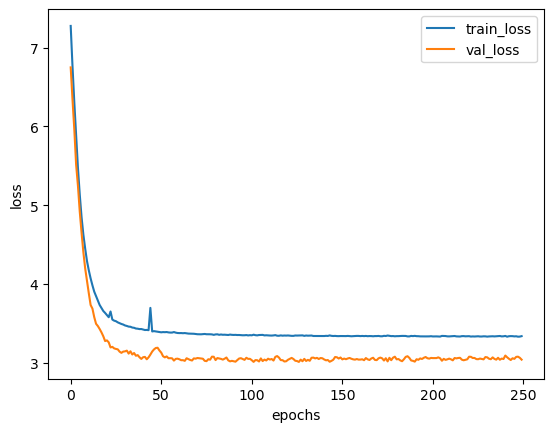

In [68]:
history_dict = history.history  # 获取训练的数据字典
train_loss = history_dict['loss']  # 训练集损失
val_loss = history_dict['val_loss']  # 验证集损失
 
#（11）绘制训练损失和验证损失
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')  # 训练集损失
plt.plot(range(epochs), val_loss, label='val_loss')  # 验证集损失
plt.legend()  # 显示标签
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()